In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from numpy import arange
from sklearn.preprocessing import LabelBinarizer
from scipy.stats import normaltest, linregress
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
masterList= {"Fruits and Nuts":['Apples', 'Apricots', 'Cherries', 'Currants', 'Gooseberries', 'Grapes', 'Peaches and nectarines', 'Pears', 'Plums and sloes', 'Raspberries', 'Sour cherries', 'Strawberries', 
                                       'Walnuts, in shell', 'Blueberries', 'Other stone fruits', 'Other berries and fruits of the genus vaccinium n.e.c.'],
            "Vegetables and Legumes":['Asparagus', 'Broad beans and horse beans, dry', 'Broad beans and horse beans, green', 'Beans, dry', 'Cabbages', 'Carrots and turnips', 'Cauliflowers and broccoli', 
                                                    'Cucumbers and gherkins', 'Lentils, dry', 'Lettuce and chicory', 'Lupins', 'Other beans, green', 'Other pulses n.e.c.', 'Other vegetables, fresh n.e.c.', 'Peas, dry', 
                                                    'Peas, green', 'Potatoes', 'Spinach', 'Sugar beet', 'Tomatoes', 'Leeks and other alliaceous vegetables', 'Chillies and peppers, green (Capsicum spp. and Pimenta spp.)', 
                                                    'Pumpkins, squash and gourds', 'Onions and shallots, green', 'Onions and shallots, dry (excluding dehydrated)'],
             "Cereals":['Barley', 'Maize (corn)', 'Mixed grain', 'Oats', 'Rye', 'Triticale', 'Wheat'],
             "Industrial_crops" :['Mustard seed', 'Other oil seeds, n.e.c.', 'Poppy seed', 'Rape or colza seed', 'Sunflower seed', 'Soya beans', 'Linseed','Hop cones','Vetches', 'Unmanufactured tobacco']}

In [7]:
fruits_season = {
    "Spring": ["Apricots", "Cherries", "Gooseberries", "Raspberries", "Strawberries"],
    "Summer": ["Apples", "Currants", "Grapes", "Peaches and nectarines", "Pears", "Plums and sloes", "Sour cherries", "Blueberries"],
    "Autumn": ["Walnuts, in shell"],
    "Year-Round": ["Other stone fruits", "Other berries and fruits of the genus vaccinium n.e.c."]
}
vegetable_season = {
    'Spring': ['Asparagus', 'Cabbages', 'Lettuce and chicory', 'Spinach', 'Broad beans and horse beans, green', 'Carrots and turnips', 'Peas, green', 'Onions and shallots, green'],
    'Summer': ['Cucumbers and gherkins', 'Tomatoes', 'Lettuce and chicory', 'Broad beans and horse beans, green', 'Peas, green', 'Onions and shallots, green'],
    'Fall': ['Cabbages', 'Carrots and turnips', 'Cauliflowers and broccoli', 'Leeks and other alliaceous vegetables', 'Onions and shallots, dry (excluding dehydrated)', 'Pumpkins, squash and gourds', 'Peas, dry'],
    'Winter': ['Cabbages', 'Carrots and turnips', 'Onions and shallots, dry (excluding dehydrated)', 'Potatoes', 'Spinach', 'Peas, dry'],
    'Year-Round': ['Beans, dry', 'Broad beans and horse beans, dry', 'Lentils, dry', 'Other beans, green', 'Other pulses n.e.c.', 'Other vegetables, fresh n.e.c.', 'Sugar beet', 'Chillies and peppers, green (Capsicum spp. and Pimenta spp.)', 'Lupins']
}
crop_dict = {
    'Spring': ['Barley', 'Oats'],
    'Summer': ['Maize (corn)'],
    'Autumn': ['Mixed grain', 'Rye', 'Triticale', 'Wheat']
}
industrial_crops = {
    'Spring': {
        'Mustard seed',
        'Other oil seeds (n.e.c.)',
        'Poppy seed',
        'Rape or colza seed',
        'Soya beans',
        'Hop cones',
        'Vetches'
    },
    'Summer': {
        'Sunflower seed',
        'Linseed'
    },
    'Year-Round': {
        'Unmanufactured tobacco'
    }
}

In [8]:
combined_dict = {}

# Combine all values from fruits_season, vegetable_season, crop_dict and industrial_crops into combined_dict
for d in [fruits_season, vegetable_season, crop_dict, industrial_crops]:
    for k, v in d.items():
        if k in combined_dict:
            combined_dict[k].extend(v)
        else:
            combined_dict[k] = v

# Print the combined dictionary
print(combined_dict)

{'Spring': ['Apricots', 'Cherries', 'Gooseberries', 'Raspberries', 'Strawberries', 'Asparagus', 'Cabbages', 'Lettuce and chicory', 'Spinach', 'Broad beans and horse beans, green', 'Carrots and turnips', 'Peas, green', 'Onions and shallots, green', 'Barley', 'Oats', 'Other oil seeds (n.e.c.)', 'Poppy seed', 'Soya beans', 'Hop cones', 'Vetches', 'Rape or colza seed', 'Mustard seed'], 'Summer': ['Apples', 'Currants', 'Grapes', 'Peaches and nectarines', 'Pears', 'Plums and sloes', 'Sour cherries', 'Blueberries', 'Cucumbers and gherkins', 'Tomatoes', 'Lettuce and chicory', 'Broad beans and horse beans, green', 'Peas, green', 'Onions and shallots, green', 'Maize (corn)', 'Sunflower seed', 'Linseed'], 'Autumn': ['Walnuts, in shell', 'Mixed grain', 'Rye', 'Triticale', 'Wheat'], 'Year-Round': ['Other stone fruits', 'Other berries and fruits of the genus vaccinium n.e.c.', 'Beans, dry', 'Broad beans and horse beans, dry', 'Lentils, dry', 'Other beans, green', 'Other pulses n.e.c.', 'Other vegeta

In [4]:
fao_data = pd.read_csv("datasets/master_data_processed.csv")
del fao_data['Unnamed: 0']
len(list(fao_data.columns))

30

In [5]:
# Define a lambda function to apply the condition
category_func = lambda x: next((k for k, v in masterList.items() if x in v), None)

# Apply the lambda function to create new column
fao_data['Category'] = fao_data['Item'].apply(category_func)

In [9]:
# Define a lambda function to apply the condition
season_func = lambda x: next((k for k, v in combined_dict.items() if x in v), None)

# Apply the lambda function to create new column
fao_data['Crop_season'] = fao_data['Item'].apply(season_func)


In [10]:
df = fao_data
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
#df.reset_index(drop=True, inplace=True)
df.set_index("Year", inplace=True)
df.index.name = None
df

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Insecticides – Other,Insecticides – Pyrethroids,Mineral Oils,Plant Growth Regulators,Rodenticides – Other,Herbicides – Bipiridils,Herbicides – Sulfonyl ureas,Rodenticides – Anti-coagulants,Category,Crop_season
1990-01-01,1787300,609000,954400,Apples,26.3272,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Fruits and Nuts,Summer
1990-01-01,1787300,609000,954400,Apricots,2.5781,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Fruits and Nuts,Spring
1990-01-01,1787300,609000,954400,Asparagus,2.7611,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Vegetables and Legumes,Spring
1990-01-01,1787300,609000,954400,Barley,5.3558,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Cereals,Spring
1990-01-01,1787300,609000,954400,"Beans, dry",3.0736,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Vegetables and Legumes,Year-Round
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,1265477,192182,446396,Sugar beet,74.1402,32.0,52.0,1655.0,2851.0,3180.0,...,20739.0,121.0,359.0,2233.0,16.0,0.000000,134.0,0.1,Vegetables and Legumes,Year-Round
2020-01-01,1265477,192182,446396,Sunflower seed,2.0567,32.0,52.0,1655.0,2851.0,3180.0,...,20739.0,121.0,359.0,2233.0,16.0,0.000000,134.0,0.1,Industrial_crops,Summer
2020-01-01,1265477,192182,446396,Tomatoes,268.7368,32.0,52.0,1655.0,2851.0,3180.0,...,20739.0,121.0,359.0,2233.0,16.0,0.000000,134.0,0.1,Vegetables and Legumes,Summer
2020-01-01,1265477,192182,446396,Triticale,5.9663,32.0,52.0,1655.0,2851.0,3180.0,...,20739.0,121.0,359.0,2233.0,16.0,0.000000,134.0,0.1,Cereals,Autumn


In [11]:
cat_names = df['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals',
       'Industrial_crops'], dtype=object)

# Trend per category

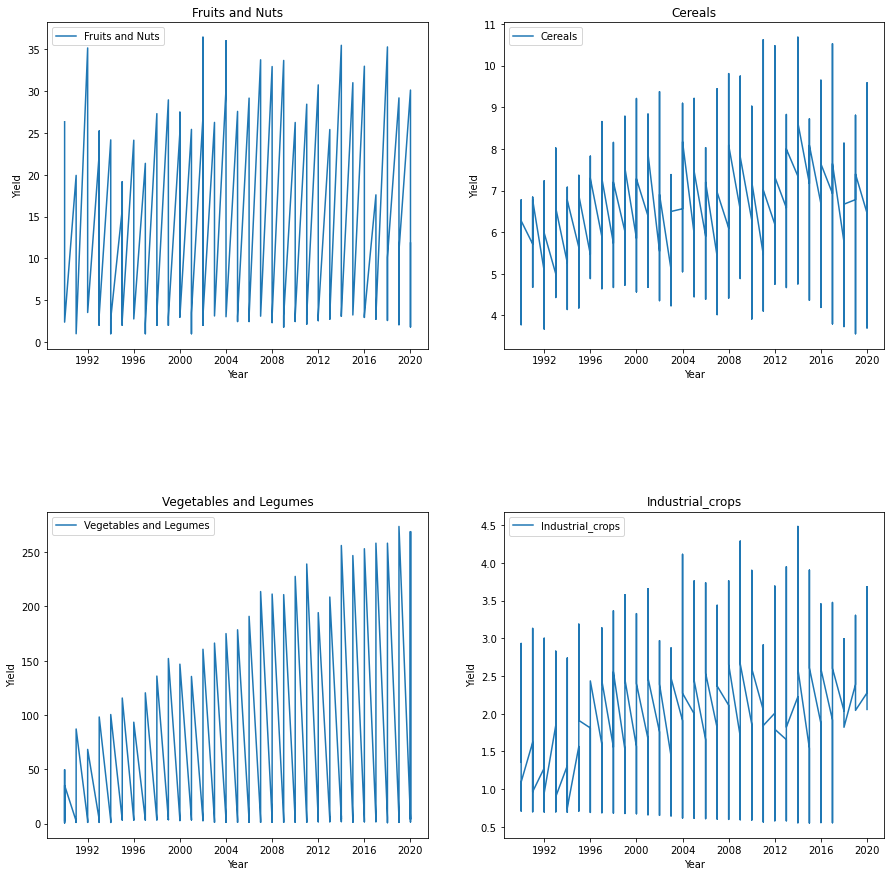

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15) )
count = 0
for cat in cat_names:
    crop_df = df[df["Category"] == cat]
    yield_data = crop_df["Yield(tonnes/ha)"]
    year_data = crop_df.index
    
    # Determine the row and column indices of the subplot
    row_idx = count % 2
    col_idx = count // 2
    
    # Select the appropriate subplot
    ax = axs[row_idx, col_idx]
    
    # Plot the yield data for the current item on the subplot
    ax.plot(year_data, yield_data, label=cat)
    
    # Set the title and axis labels for the subplot
    ax.set_title(cat)
    ax.set_xlabel('Year')
    ax.set_ylabel('Yield')
    
    # Add a legend to the subplot
    ax.legend()
    
    # change axis
    count +=1

plt.subplots_adjust(wspace=0.2, hspace=0.5)
# Show the figure
plt.show()

Correlations

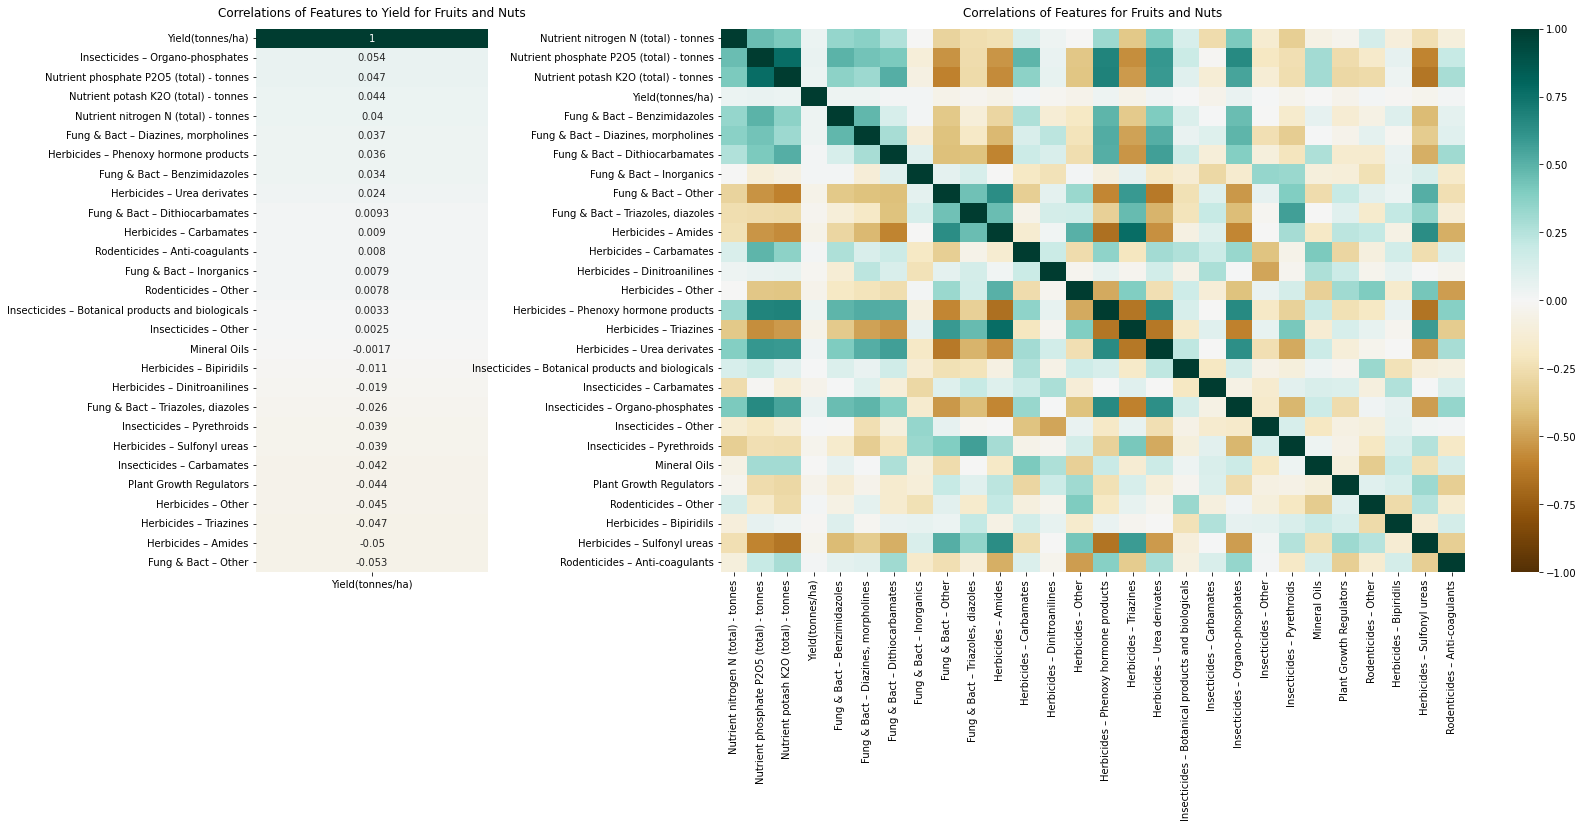

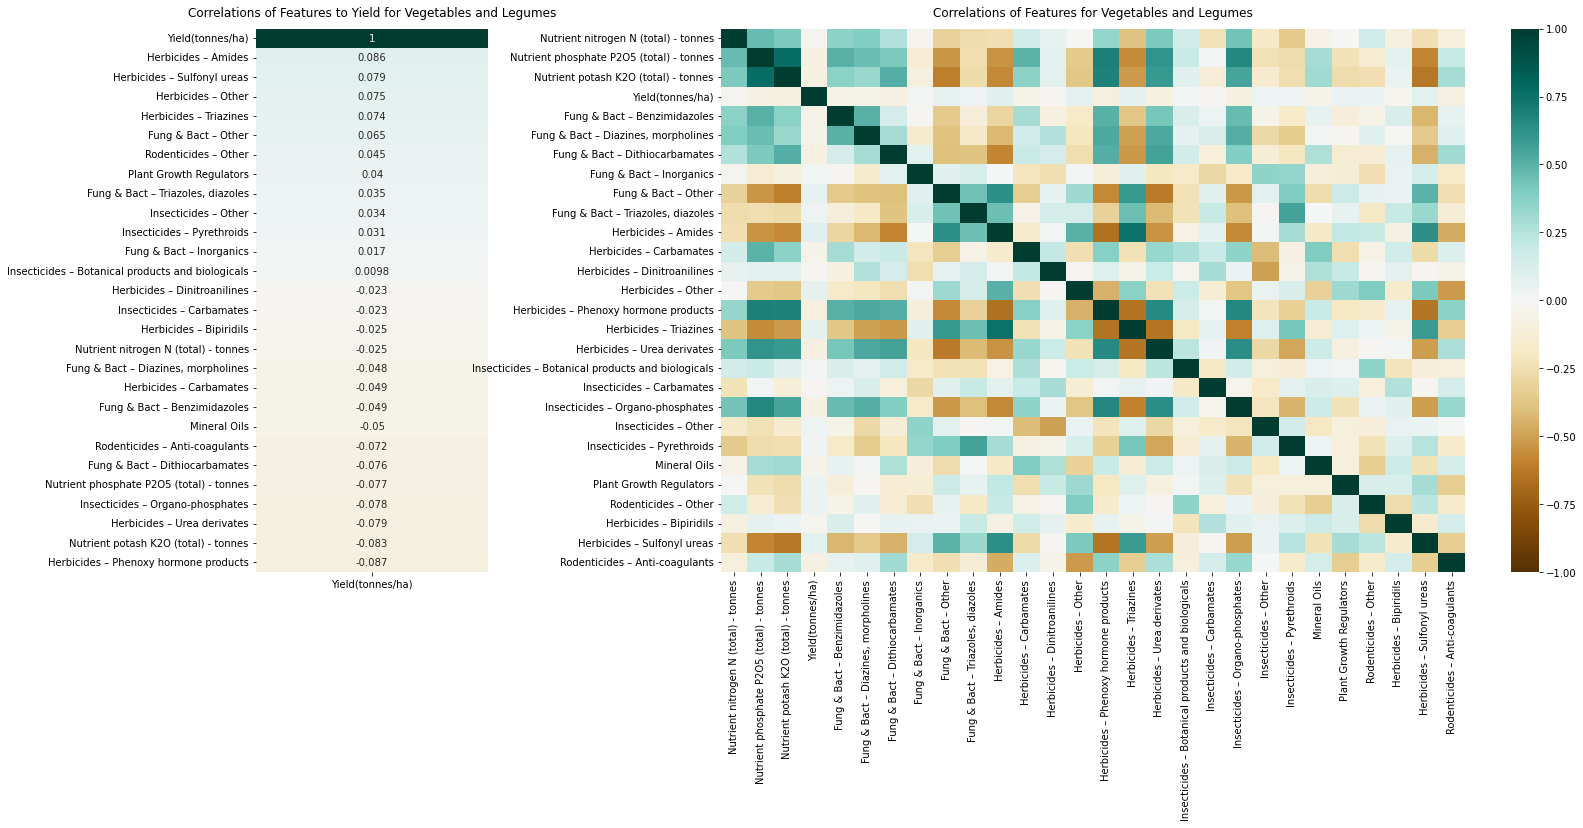

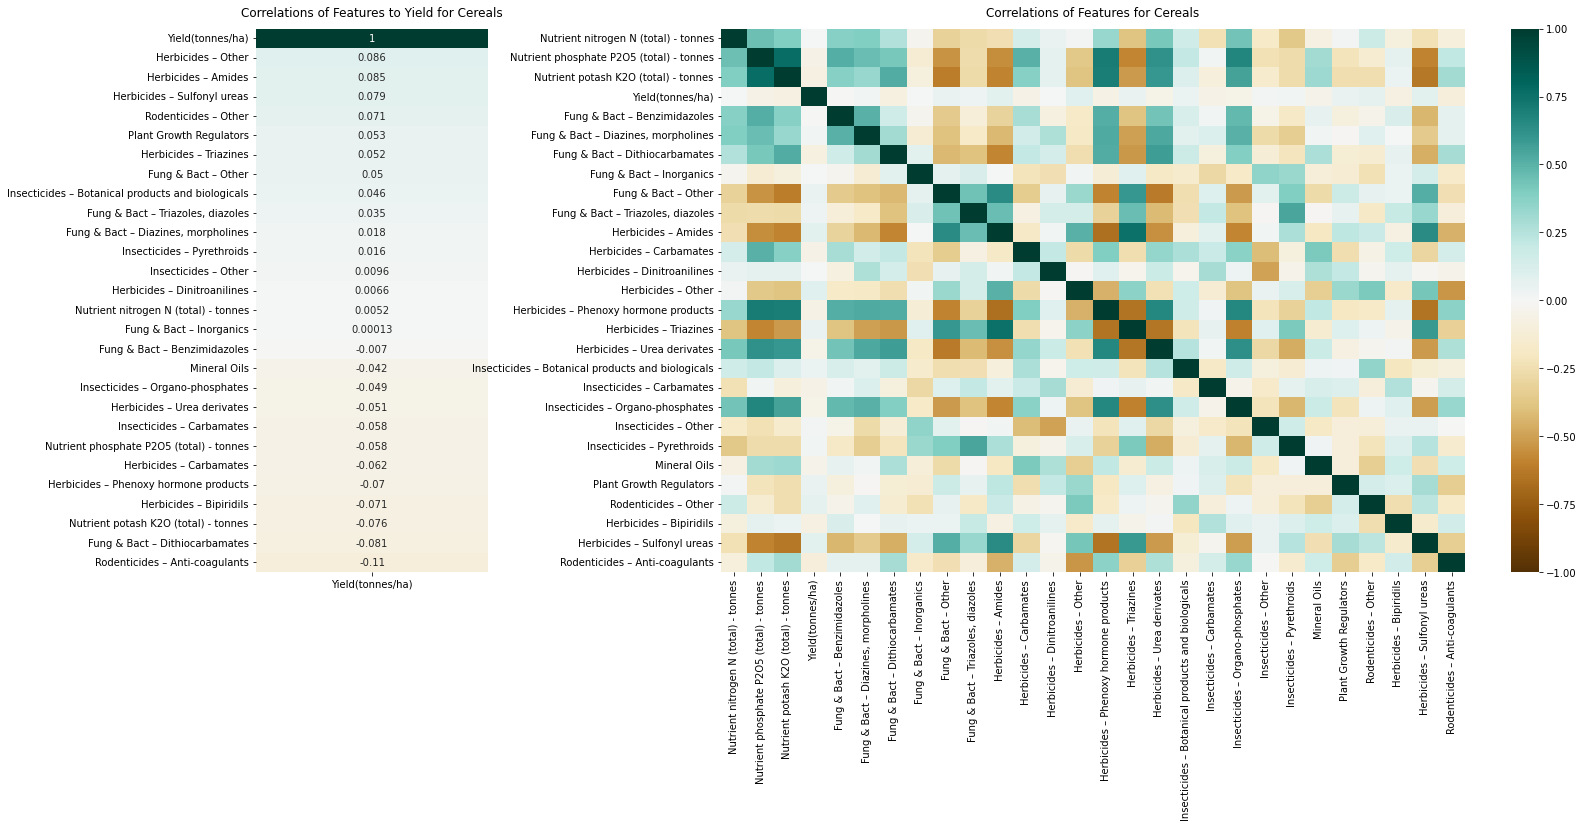

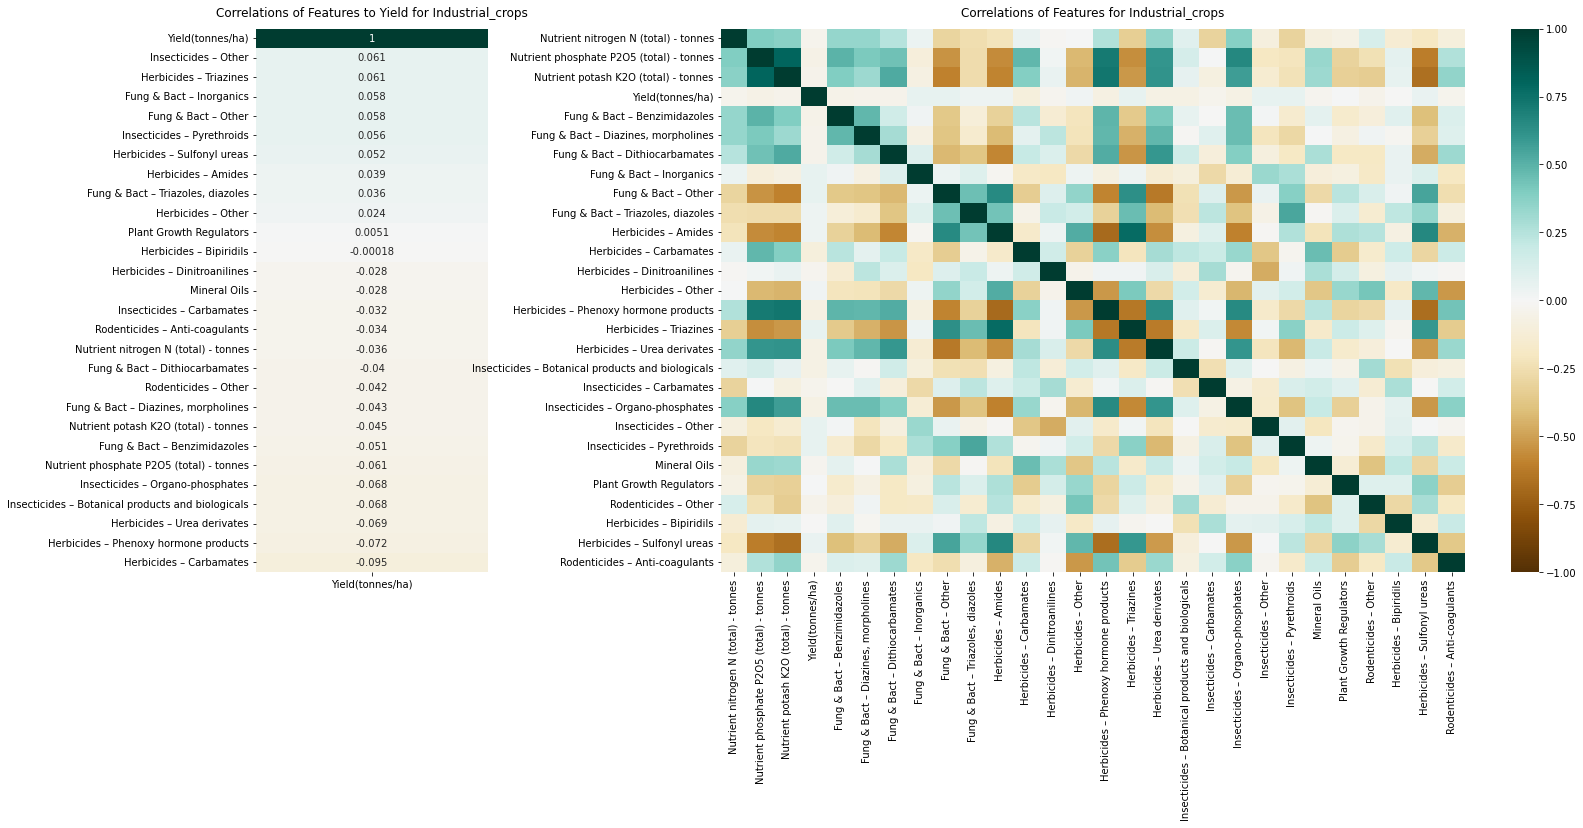

In [13]:
for cat in cat_names:
    crop_df = df[df["Category"] == cat]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), gridspec_kw={'width_ratios': [1, 4]})

    sns.heatmap(crop_df.corr(method="kendall")[['Yield(tonnes/ha)']].sort_values(by='Yield(tonnes/ha)', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax1, cbar=False)
    ax1.set_title(f'Correlations of Features to Yield for {cat}', fontdict={'fontsize':12}, pad=12)

    sns.heatmap(crop_df.corr(method="kendall"), vmin=-1, vmax=1, cmap='BrBG', ax=ax2)
    ax2.set_title(f"Correlations of Features for {cat}", fontdict={'fontsize':12}, pad=12)

    plt.subplots_adjust(wspace=0.4)
    # Set the figsize of the first subplot
    #ax1.set_position([0.1, 0.1, 0.6, 0.8])

    # Set the figsize of the second subplot
    #ax2.set_position([0.75, 0.1, 0.2, 0.8])

    plt.show()

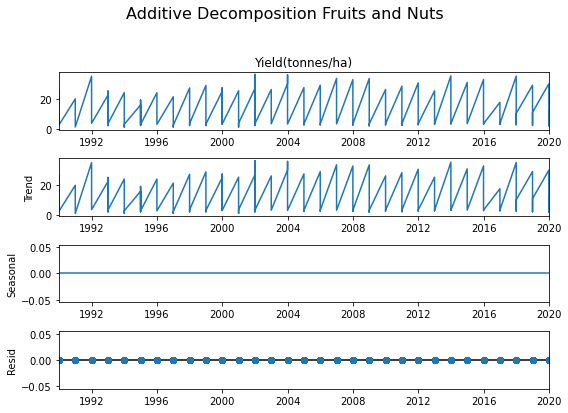

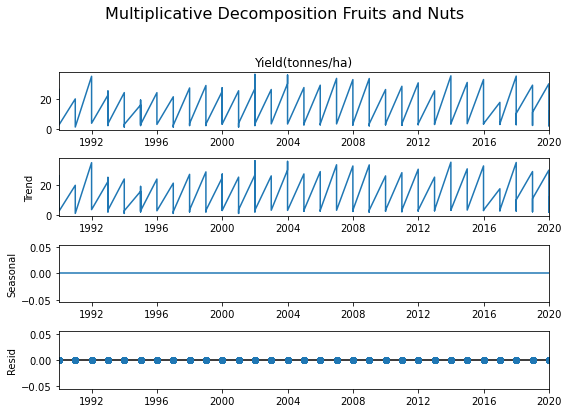

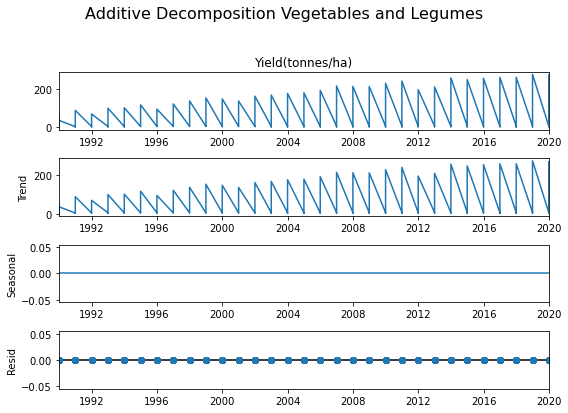

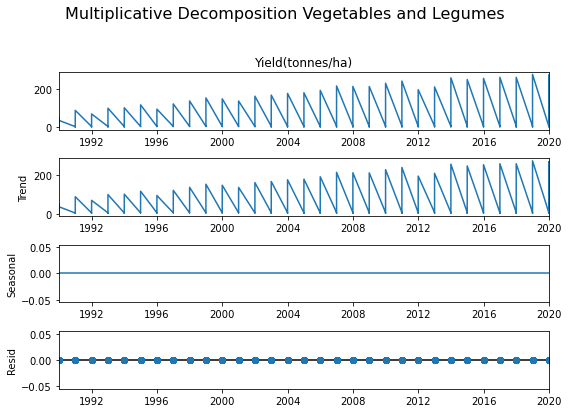

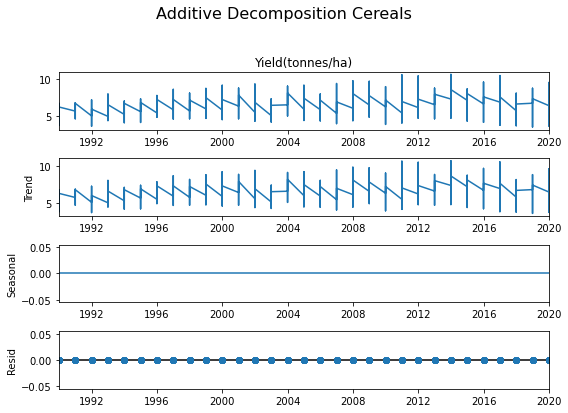

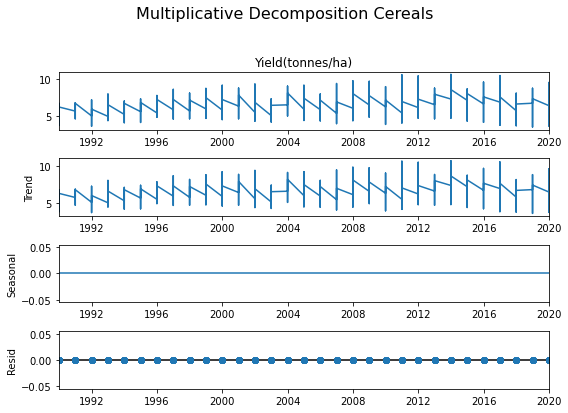

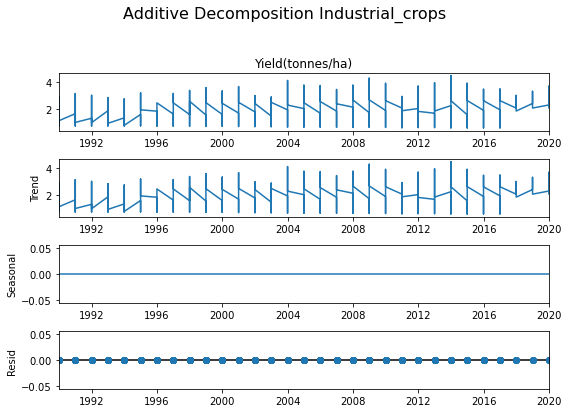

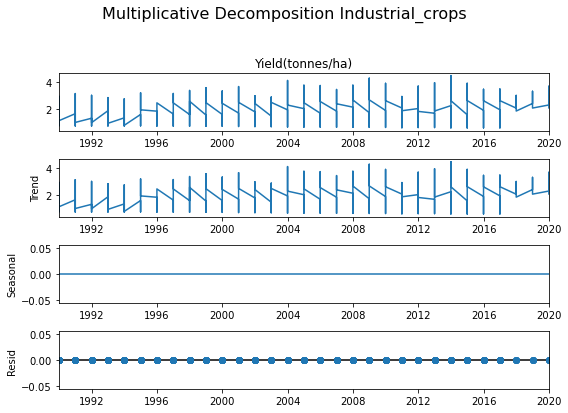

In [39]:
# Loop over each independent variable and plot against the dependent variable
for cat in cat_names:
    crop_df = df[df["Category"] == cat]

    decomp_add = seasonal_decompose(crop_df["Yield(tonnes/ha)"], model="additive", period=1)
    
    plt.rcParams.update({'figure.figsize': (8,6)})
    decomp_add.plot().suptitle(f'Additive Decomposition {cat}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    decomp_mult = seasonal_decompose(crop_df["Yield(tonnes/ha)"], model="additive", period=1)
  
    plt.rcParams.update({'figure.figsize': (8,6)})
    decomp_mult.plot().suptitle(f'Multiplicative Decomposition {cat}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()